In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from google.colab import drive
drive.mount('/content/drive') # Outputs will be saved in your google drive

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import warnings
import statsmodels
import statsmodels.tsa.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [4]:
import tensorflow as tf

from tensorflow import keras as keras
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import initializers
from keras.layers import Dense, SimpleRNN, Flatten
from keras.models import Sequential

In [5]:
tf.get_logger().setLevel('INFO')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
input_path_original_inflation = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/Original inflation/'
input_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/2_Stationary/'

In [8]:
countries = ['Finland', 'United States', 'Germany', 'France', 'Spain', 'Italy', 'Netherlands', 'Sweden', 'Belgium', 'Denmark', 'Austria', 'Poland']
transformations = ['FD', 'FD', 'none', 'FD', 'FD', 'FD', 'FD', 'none', 'none', 'FD', 'none', 'FD']

In [9]:
macro_variables = ['inflation', 'unemployment', 'imports', 'exports', 'bond_yield', 'exchange', 'ppi', 'bci', 'cci', 'construction', 'manufacturing', 'share_prices', 'gdp', 'house_prices', 'investment', 'domestic_demand']
common_variables = ['oil', 'silver', 'eurusd', 'eurcfh', 'spx', 'world']
all_variables = macro_variables + common_variables

In [10]:
def get_data(variable, path_in = input_path):
    input_file = path_in + variable +'.csv'
    data = pd.read_csv(input_file, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.astype(float)
    data = data.sort_index()
    return data

In [11]:
def drop_constant_columns(data):
    non_constant_columns = data.columns[data.nunique() > 1]
    return data[non_constant_columns].copy()

In [12]:
# create the data matrix

init_index = get_data("inflation_Finland", input_path)
df = pd.DataFrame(index = init_index.index)

for variable in macro_variables:
    for country in countries:
        data = get_data(variable + "_" + country)
        new_column_name = variable + "_" + country
        data = data.rename({'Data': new_column_name}, axis=1)
        df[new_column_name] = data

for variable in common_variables:
    data = get_data(variable + "_" + 'Finland')
    new_column_name = variable + "_" + 'common'
    data = data.rename({'Data': new_column_name}, axis=1)
    df[new_column_name] = data

df = drop_constant_columns(df)

In [13]:
def split_sequences(sequences, no_steps_in, no_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + no_steps_in
        out_end_ix = end_ix + no_steps_out - 1

        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break

        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

# Model Specification

In [14]:
def create_RNN(no_features, no_steps_in, no_steps_out):
    model = Sequential()
    model.add(SimpleRNN(256, activation='tanh', return_sequences=True, input_shape = (no_steps_in, no_features)))
    model.add(SimpleRNN(128,activation = 'tanh'))
    model.add(Dense(no_steps_out))
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),loss = 'mse')
    return model

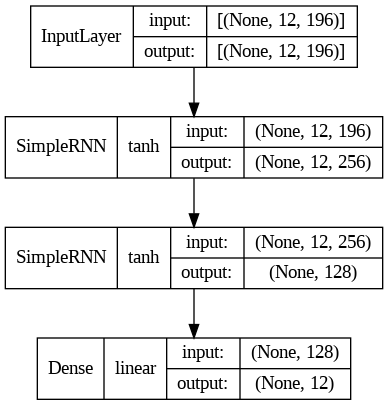

In [15]:
# plot the model
model = create_RNN(196, 12, 12)
output_file = '/content/drive/MyDrive/Colab Notebooks/Gradu/Figures/model_rnn.png'
tf.keras.utils.plot_model(model, to_file=output_file, show_shapes=True, show_layer_activations=True, show_layer_names=False)

# Forecasting for 2022

In [16]:
horizons = [1,2,3,6,9,12]
steps_in = 12 # use previous 12 observations to predict the next horizon
features = df.shape[1]

for (country, transformation) in zip(countries,transformations):
    warnings.filterwarnings('ignore')

    print("country: " + str(country))
    print()

    # original inflation for reversing stationarity and calculating the RMSE
    split_point = len(df)-12
    original_inflation = "original_inflation_" + str(country)
    data_original = get_data(original_inflation, input_path_original_inflation)
    test_original = data_original[split_point:] # original inflation for 2022

    # train data
    train = np.array(df.loc['2000-01-01':'2021-12-01'])
    train_out = np.array(df.loc['2000-01-01':'2021-12-01']['inflation_' + country])

    # normalise features
    scaler = StandardScaler()
    scaler.fit(train)
    normalized_train = scaler.transform(train)

    # normalise target as well (needed especially for time series that aren't differenced because otherwise the scales are too different)
    target_scaler = StandardScaler()
    train_out = train_out.reshape(len(train_out), 1)
    target_scaler.fit(train_out)
    normalized_train_out = target_scaler.transform(train_out)

    train_set = np.hstack((normalized_train, normalized_train_out))

    # out-of-sample-inputs
    test = np.array(df.loc['2021-01-01':'2021-12-01'])
    normalized_test = scaler.transform(test)
    test_set = normalized_test.reshape((1, steps_in, features))

    for horizon in horizons:
        keras.utils.set_random_seed(42) # set random seed for reproducability
        warnings.filterwarnings('ignore')
        horizon_test = test_original[:horizon]
        forecast_df = pd.DataFrame(index=horizon_test.index)
        forecast_df['Actual'] = horizon_test['Data']

        X,y = split_sequences(train_set, steps_in, horizon)

        es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.01, patience = 10,verbose = 0)
        # train the model
        model = create_RNN(features, steps_in, horizon)
        fit = model.fit(X, y, verbose=0, epochs=500, validation_split=0.1, callbacks = [es])

        forecast_normalized = model.predict(test_set, verbose = 0)
        forecast_denormalized = target_scaler.inverse_transform(forecast_normalized)
        forecast = forecast_denormalized.flatten()

        # we need to reverse the stationarity
        if transformation == "FD":
            last_observed_value = data_original[:split_point]
            last_observed_value = last_observed_value.values
            last_observed_value = last_observed_value[-1] # get the last observed value, i.e. 2021-12
            forecasted_original = []
            for pred in forecast:
                forecasted_value = last_observed_value + pred
                forecasted_original.append(forecasted_value)
                last_observed_value = forecasted_value
            forecast = forecasted_original
            forecast = np.concatenate(forecast)
            forecast_df['Forecast'] = forecast
        else:
            forecast_df['Forecast'] = forecast

        rmse = np.sqrt(mean_squared_error(forecast_df['Actual'], forecast_df['Forecast']))
        print("horizon: ", horizon)
        print('RMSE: ', round(rmse,3))
        print()

    print()
    print("##################")

country: Finland

horizon:  1
RMSE:  0.699

horizon:  2
RMSE:  0.779

horizon:  3
RMSE:  0.959

horizon:  6
RMSE:  1.664



horizon:  9
RMSE:  2.529



horizon:  12
RMSE:  3.118


##################
country: United States

horizon:  1
RMSE:  0.427

horizon:  2
RMSE:  0.248

horizon:  3
RMSE:  0.953

horizon:  6
RMSE:  1.71

horizon:  9
RMSE:  2.577

horizon:  12
RMSE:  2.396


##################
country: Germany

horizon:  1
RMSE:  1.736

horizon:  2
RMSE:  1.727

horizon:  3
RMSE:  2.108

horizon:  6
RMSE:  3.175

horizon:  9
RMSE:  3.825

horizon:  12
RMSE:  4.752


##################
country: France

horizon:  1
RMSE:  0.036

horizon:  2
RMSE:  0.532

horizon:  3
RMSE:  1.15

horizon:  6
RMSE:  2.014

horizon:  9
RMSE:  3.109

horizon:  12
RMSE:  3.393


##################
country: Spain

horizon:  1
RMSE:  0.557

horizon:  2
RMSE:  0.739

horizon:  3
RMSE:  2.196

horizon:  6
RMSE:  2.389

horizon:  9
RMSE:  3.603

horizon:  12
RMSE:  3.145


##################
country: Italy

horizon:  1
RMSE:  0.768

horizon:  2
RMSE:  1.117

horizon:  3
RMSE:  1.44

horizon:  6
RMSE:  2.112

horizon:  9
RMSE:  3.261

horizon:  12
RMSE:  4.708

